In [1]:
suppressPackageStartupMessages(library(VGAM))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))

In [2]:
vcf_file <- "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/monocyte_pool.vcf.gz.gz"
cell_lines <- system(paste("bcftools query -l", vcf_file), intern = T)

In [3]:
vcf_file <- "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/merged_ancestries_microglia.vcf.gz"
cell_lines <- system(paste("bcftools query -l", vcf_file), intern = T)

In [4]:
geno_fix <- function (x) {
    switch(x,
       "0|0"=0,
       "1|0"=0.5,
       "0|1"=0.5,
       "1|1"=1, 
       "0/0"=0,
       "1/0"=0.5,
       "0/1"=0.5,
       "1/1"=1, 
           NA)
}

In [4]:
geno = fread(cmd = paste("bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t%ID\t%AC\t%AN\t%AF[\t%GT]\n'", vcf_file), header = F, 
                  col.names = c("CHROM", "POS", "REF", "ALT", "ID", "AC", "AN", "AF", cell_lines))
for (x in cell_lines) {
    geno[[x]] <- sapply(geno[[x]], geno_fix)
}

Warning message in fread(cmd = paste("bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t%ID\t%AC\t%AN\t%AF[\t%GT]\n'", :
“Discarded single-line footer: <<chr1	106634403	A	G	chr>>”


In [292]:
write_feather(geno, "~/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather")

In [293]:
setDT(geno)

In [ ]:
geno <- read_feather("~/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/monocyte_pool.feather", col_select = NULL, as_data_frame = TRUE, mmap = TRUE)
setDT(geno)

In [3]:
geno <- read_feather("~/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather", col_select = NULL, as_data_frame = TRUE, mmap = TRUE)
setDT(geno)

In [4]:
head(geno)

index,position,contig,variantID,refAllele,altAllele,GSA8_0_RAJBrain_NPBB306,GSA8_0_RAJBrain_NPBB307,GSA8_0_RAJBrain_NPBB310,GSA8_0_RAJBrain_NPBB314,GSA8_0_RAJBrain_NPBB318,GSA8_0_RAJBrain_NPBB319,GSA8_0_RAJBrain_NPBB312,GSA8_0_RAJBrain_NPBB334,GSA8_0_RAJBrain_NPBB324,GSA8_0_RAJBrain_NPBB305,GSA8_0_RAJBrain_NPBB333,GSA8_0_RAJBrain_NPBB308,GSA8_0_RAJBrain_NPBB316,GSA8_0_RAJBrain_NPBB331
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:11171:CCTTG:C,11171,chr1,chr1:11171:CCTTG:C,CCTTG,C,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,NA,0,0,0
chr1:23197:TTAAAA:T,23197,chr1,chr1:23197:TTAAAA:T,TTAAAA,T,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,NA,NA,NA
chr1:23308:G:C,23308,chr1,chr1:23308:G:C,G,C,0,0,0,0,0,0,0,0,0,NA,NA,0,0,0
chr1:48824:T:C,48824,chr1,chr1:48824:T:C,T,C,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,0,0
chr1:54490:G:A,54490,chr1,chr1:54490:G:A,G,A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,0,0
chr1:60351:A:G,60351,chr1,chr1:60351:A:G,A,G,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,0,0,0


In [ ]:
geno <- mutate(geno, 
               AC = apply(geno[,..cell_lines], 1, function(x) { sum(x[!is.na(x)]) }), .after = "altAllele")%>%
        mutate(AF = AC / length(cell_lines), .after = "AC")%>%
        mutate(MAF = ifelse(AF > 0.5, 1-AF, AF), .after = "AC")

In [ ]:
head(geno)

In [ ]:
geno_flipped <- mutate(geno, AC = length(cell_lines) - AC, AF = 1-AF, tmp = refAllele, REF=altAllele)%>%mutate(ALT = tmp)%>%select(-tmp)%>%
    mutate(ID = paste(contig, position, refAllele, altAllele, sep=":"))

In [230]:
obs_file <- "~/projects/bqtls/SecondRound_bQTLs/Monocytes/PU1_mono_allelic_out.txt"

In [12]:
obs_file <- "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/PU1_ALL_mic_allelic_out.txt"

In [13]:
obs <- fread(obs_file, sep = "\t", header = F, skip = 1) 
obs <- obs[,1:(ncol(obs)-1)]
colnames(obs) <- unlist(strsplit(readLines(obs_file, 1), "\t"))

In [14]:
nrow(obs[totalCount >= 100])

[1] 1044

In [15]:
if (!all(obs$variantID %in% geno$variantID)) {
    stop("Allele flipping in", obs_file)
}

In [16]:
if (!all(obs$variantID %in% c(geno$varinatID, geno_flipped$variantID))) {
    stop("EEK")
}

ERROR: Error in obs$variantID %in% c(geno$varinatID, geno_flipped$variantID): object 'geno_flipped' not found


## Do deconvolution

I believe that it works in the following way:
1. We learn representations of cell lines from CHIP seq variant abundances (learn mixing ratios that best estimate final allele counts)
2. We use this learned representation vector to estimate new AFs
3. We look for variants that are skewed in some unexpected way

In [18]:
total_thresh <- 30
maf_thresh <- 0.05
obs_sub <- obs[(totalCount >= total_thresh) & (totalCount != refCount) & (totalCount != altCount)]
geno_sub <- geno[(MAF >= maf_thresh)]
variants_keep <- intersect(obs_sub$variantID, geno_sub$variantID)
obs_sub <- obs_sub[match(variants_keep, variantID)]
geno_sub <- geno[match(variants_keep, variantID)]

In [19]:
X <- as.matrix(geno[match(variants_keep, variantID), ..cell_lines])
dim(X)

[1] 11740    14

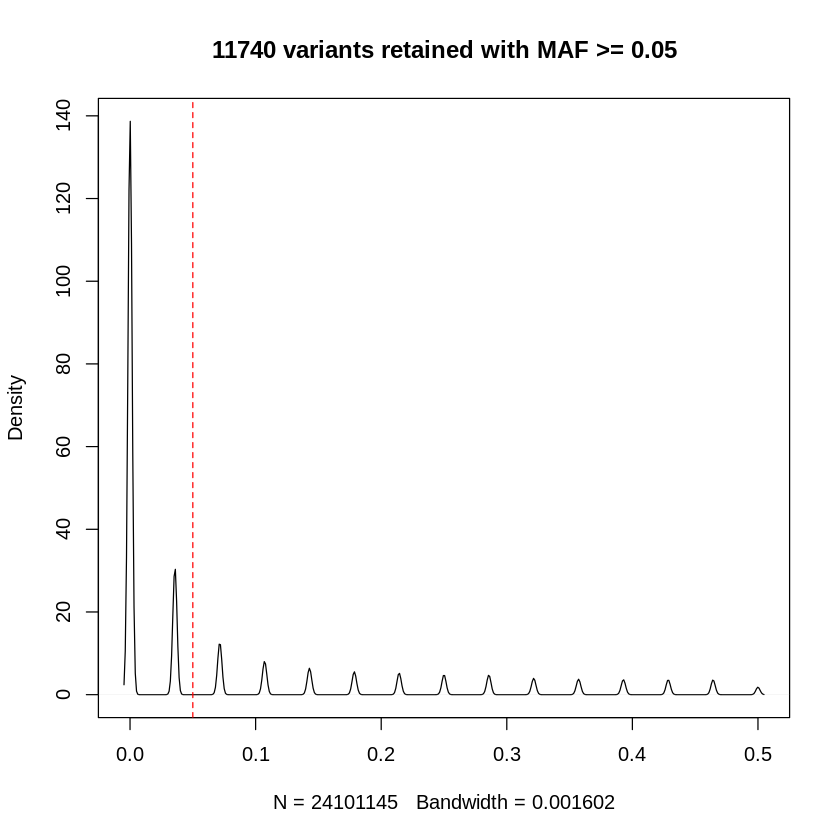

In [20]:
plot(density(geno$MAF), main = paste(nrow(X), "variants retained with MAF >= 0.05"))
abline(v=0.05, col='red', lty='dashed')

In [21]:
# observed allelic ratios
y <- with(obs_sub, altCount / totalCount)
length(y)

[1] 11740

In [22]:
library(ggplot2)

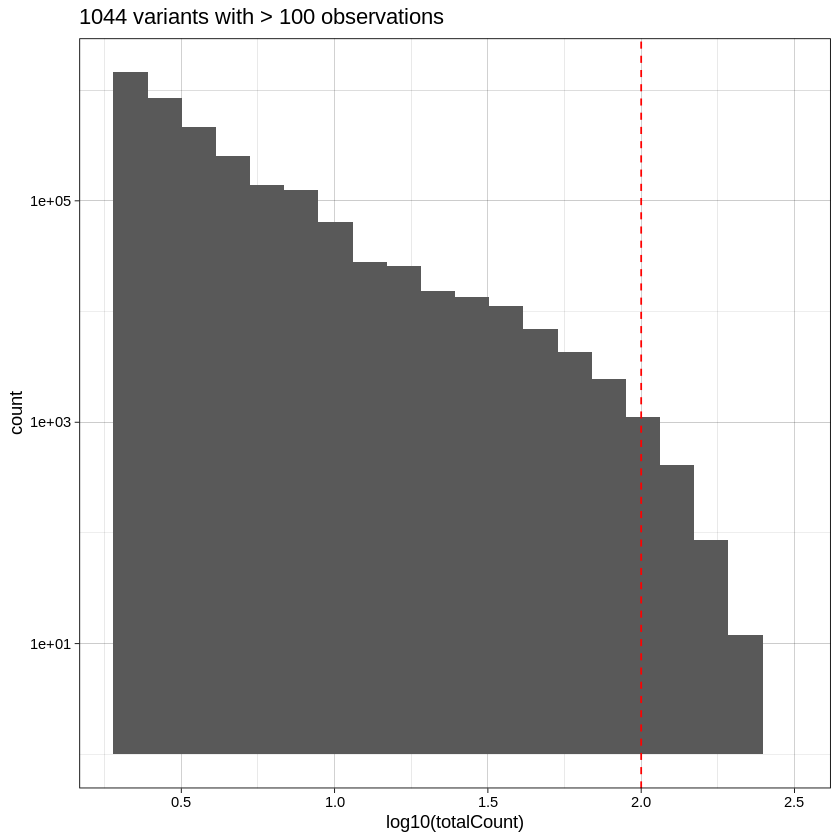

In [23]:
ggplot(obs, aes(x = log10(totalCount))) +  theme_linedraw()+
geom_histogram(bins = 20) +
scale_y_log10()+
geom_vline(xintercept = log10(100), col='red', lty='dashed')+
labs(title = nrow(obs[totalCount >= 100])%>%paste("variants with > 100 observations"))

In [24]:
stopifnot(all(!is.na(y)))
stopifnot(all(is.numeric(y)))

In [25]:
fit <- lm(y ~ 0+X)

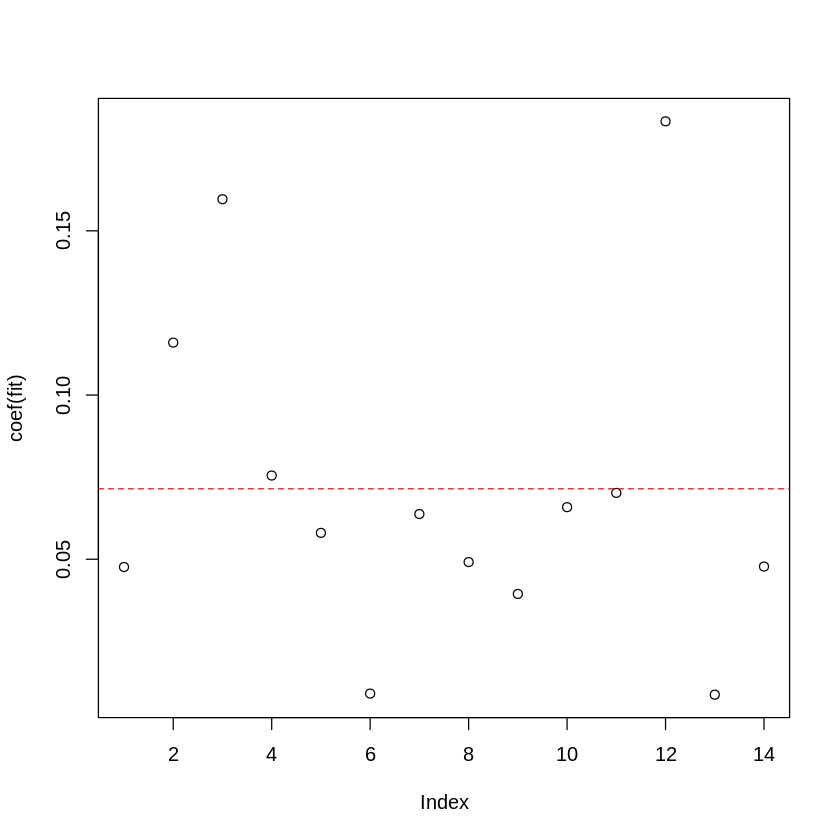

In [26]:
plot(coef(fit))
abline(h = 1/length(cell_lines), col = 'red', lty='dashed')

In [27]:
w <- coef(fit)
stopifnot(all(paste0('X', cell_lines) == names(w)))
names(w) <- cell_lines

In [28]:
afs_expected <- geno_sub$AF

In [29]:
# Multiply each row of X by w and sum to get predicted AFs
# so  X %*% x
mu = X  %*% w

In [35]:
min(mu,na.rm=T)
max(mu,na.rm=T)

[1] 0.008750588

[1] 0.9697679

In [36]:
mu

0.06155436
NA
0.89359446
0.35375909
0.20567676
0.79332147
0.45714534
0.50873710
0.50873710
NA
NA


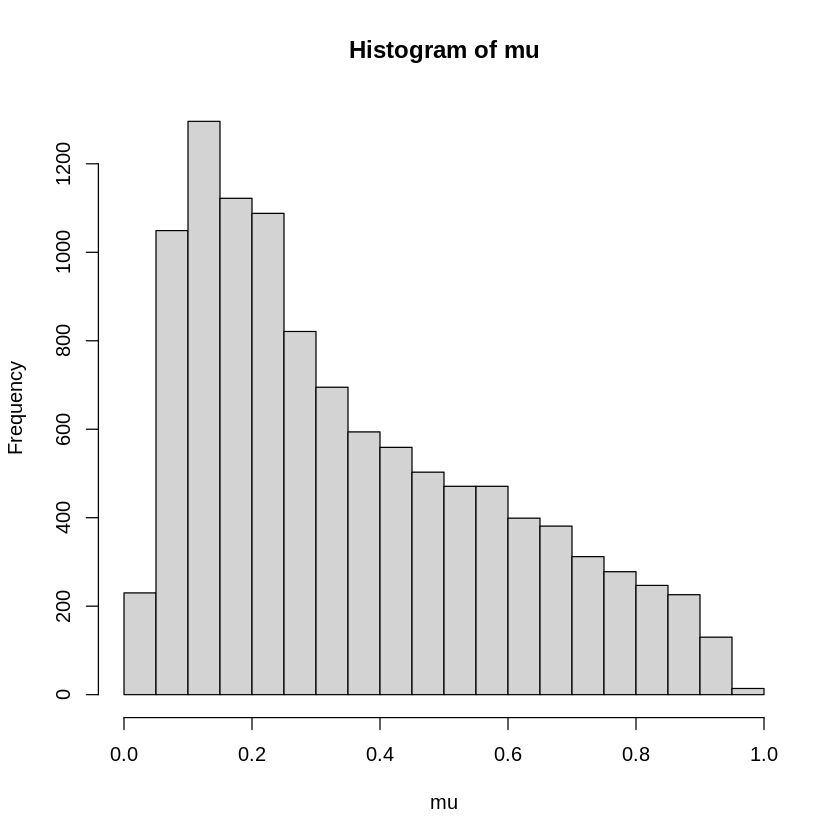

In [37]:
hist(mu)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 854 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 854 rows containing missing values (`geom_point()`).”


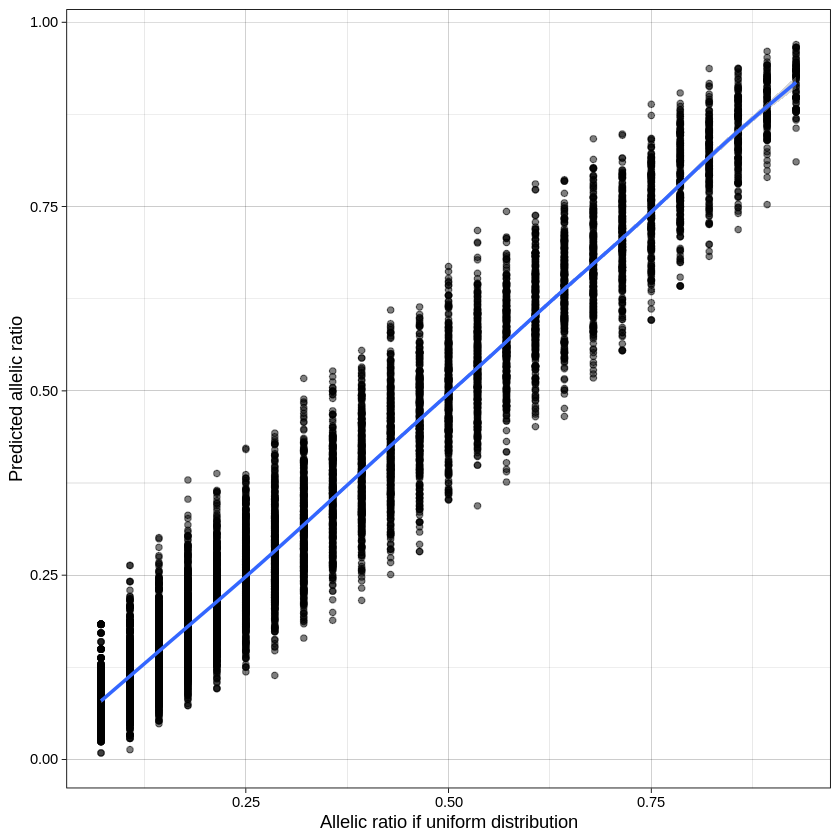

In [38]:
data.frame(mu, afs_expected)%>%
ggplot(aes(x = afs_expected, y = mu)) + 
geom_point(alpha = 0.5) +
theme_linedraw()+
geom_smooth()+
labs(x = "Allelic ratio if uniform distribution", y = "Predicted allelic ratio")

Warning message:
“Removed 854 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 854 rows containing missing values (`geom_point()`).”


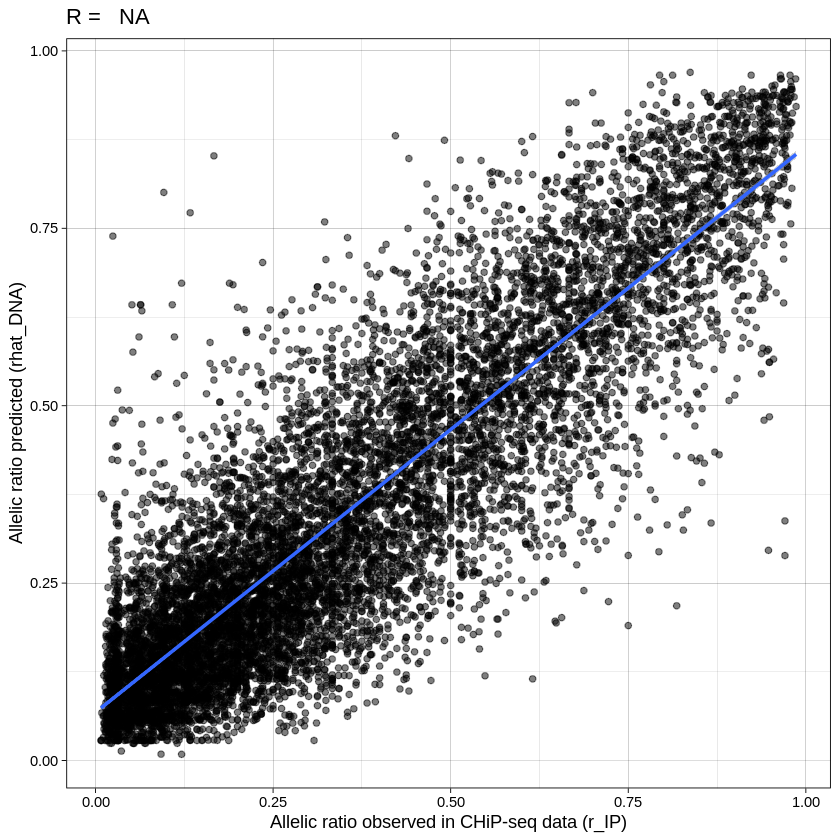

In [39]:
# Then we also want to plot predicted allelic ratio against ACTUAL allelic ratio
observed_allelic_ratio <- obs_sub$altCount / obs_sub$totalCount

ggplot(data.frame(observed_allelic_ratio, predicted_allelic_ratio = mu),
       aes(x = observed_allelic_ratio, y = mu)) +
geom_point(alpha = 0.5) +
geom_smooth(method=lm, formula = y ~ x, se = TRUE) +
theme_linedraw()+
labs(x = "Allelic ratio observed in CHiP-seq data (r_IP)", y = "Allelic ratio predicted (rhat_DNA)", title = paste0("R = ", formatC(cor(observed_allelic_ratio, mu)^2, digits = 3)))

## Then run beta model

## Fit Betabinomial distribution to $y_i | n_i$

Prior: $$r_{\text{IP}} \vert \hat{r}_D \sim \text{Beta}(\mu = \hat{r}_D, c_{\text{IP}})$$

Estimate $$y_i \vert n_i \sim \text{BB}(\mu = \hat{r}_D, c_{\text{IP}}')$$

In [40]:
fit <- vglm(cbind(altCount, refCount) ~ identitylink(offset(mu)), betabinomial(lmu = identitylink, lrho = identitylink), obs_sub, crit = "coef")
# Uses the mu to predict a 2-dimensional vector of ref and alt
# Automatically conditions on alt_count + ref_count
# rho = 1 / (1 + alpha + beta)
# what david wants conc = (1-rho)/rho
# rho is not actually concentration (called the correlation parameter)

In [41]:
# rho if 0 is normal distribution

In [42]:
coef(fit, matrix = TRUE)

,mu,rho
(Intercept),0.02612299,0.05785618
identitylink(offset(mu)),0.94775678,0.00000000


In [43]:
rho <- coef(fit, matrix = TRUE)[1,2]
conc <- (1-rho)/rho

In [44]:
mu <- as.double(mu)

In [45]:
conc

[1] 16.28424

Notes from meeting with David 10/2/23
* if the concentration is like 300 then it's almost binomial, not beta-binomial
* 10-50 common for seq dataobs_sub
* low 10s is surprisingly noisy

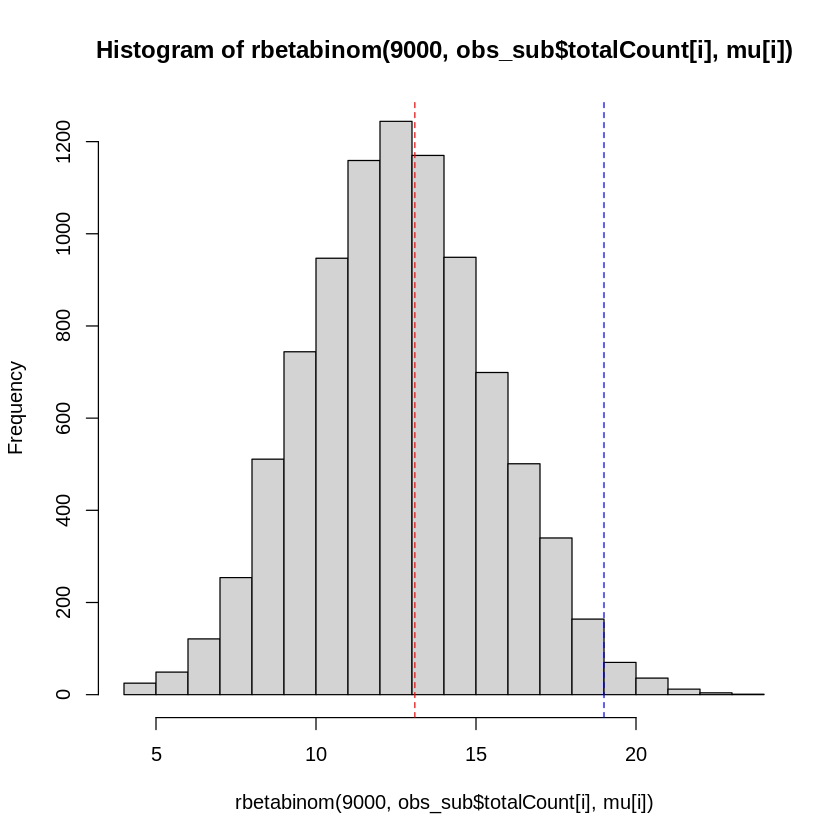

In [46]:
i = 4
crit1 <- obs_sub$totalCount[i]*mu[i]
crit2 <- obs_sub$altCount[i]
hist(rbetabinom(9000, obs_sub$totalCount[i], mu[i]))
abline(v = crit1, col = 'red', lty='dashed')
abline(v = crit2, col = 'blue', lty='dashed')

### Calculate p-value correctly depending on whether or not altCount > totalCount*$\mu$

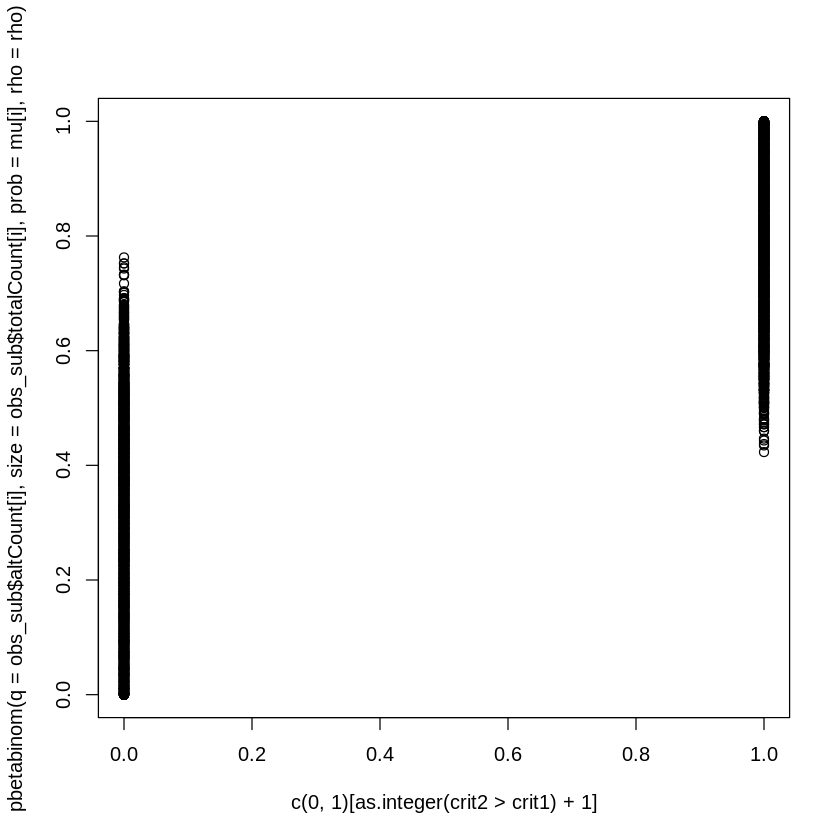

In [47]:
i = 1:nrow(obs_sub)
crit1 <- obs_sub$totalCount[i]*mu[i]
crit2 <- obs_sub$altCount[i]

plot(c(0,1)[as.integer(crit2 > crit1)+1],
     pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho))

Warning message:
“Removed 854 rows containing non-finite values (`stat_ydensity()`).”


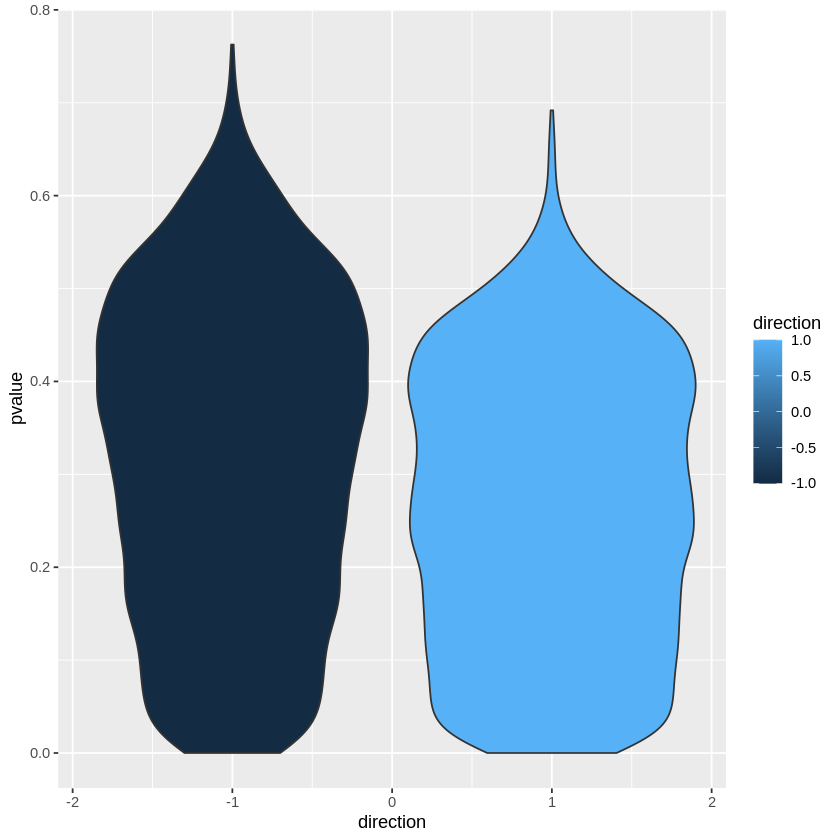

In [48]:
idx <- crit2 > crit1
data.frame(direction = c(-1L, 1L)[as.integer(idx)+1],
     pvalue = ifelse(idx, 
            1-pbetabinom(q = obs_sub$altCount[i]-1, size = obs_sub$totalCount[i], prob = mu[i], rho = rho),
            pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
           ))%>%
ggplot(aes( x= direction, y = pvalue, group = direction, fill = direction))+ geom_violin()

Warning message:
“Removed 854 rows containing non-finite values (`stat_ydensity()`).”


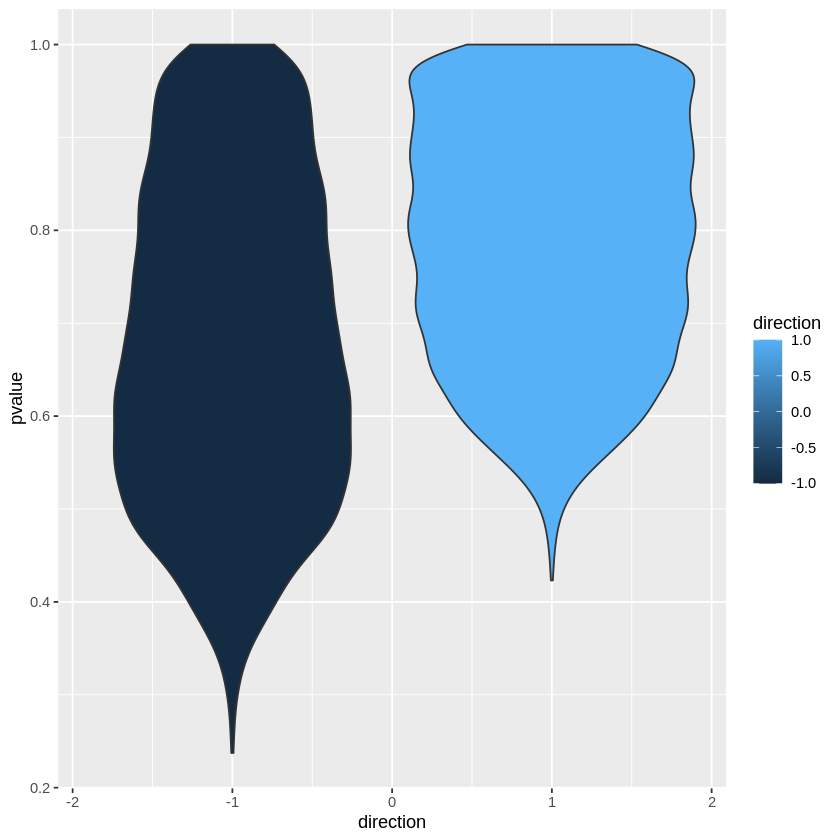

In [49]:
idx <- crit2 > crit1
data.frame(direction = c(-1L, 1L)[as.integer(idx)+1],
     pvalue = ifelse(idx, 
            pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho),
            1-pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
           ))%>%
ggplot(aes( x= direction, y = pvalue, group = direction, fill = direction))+ geom_violin()

Warning message:
“Removed 854 rows containing non-finite values (`stat_ydensity()`).”


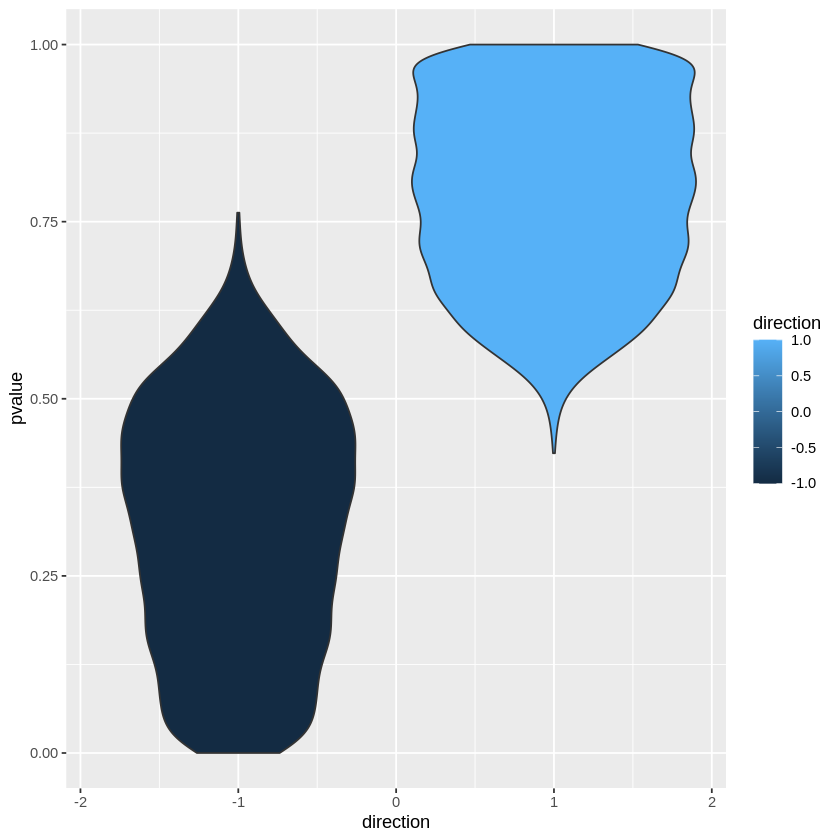

In [50]:
idx <- crit2 > crit1
data.frame(direction = c(-1L, 1L)[as.integer(idx)+1],
     pvalue = ifelse(idx, 
            pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho),
            pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
           ))%>%
ggplot(aes( x= direction, y = pvalue, group = direction, fill = direction))+ geom_violin()

### Calculate p-values correctly

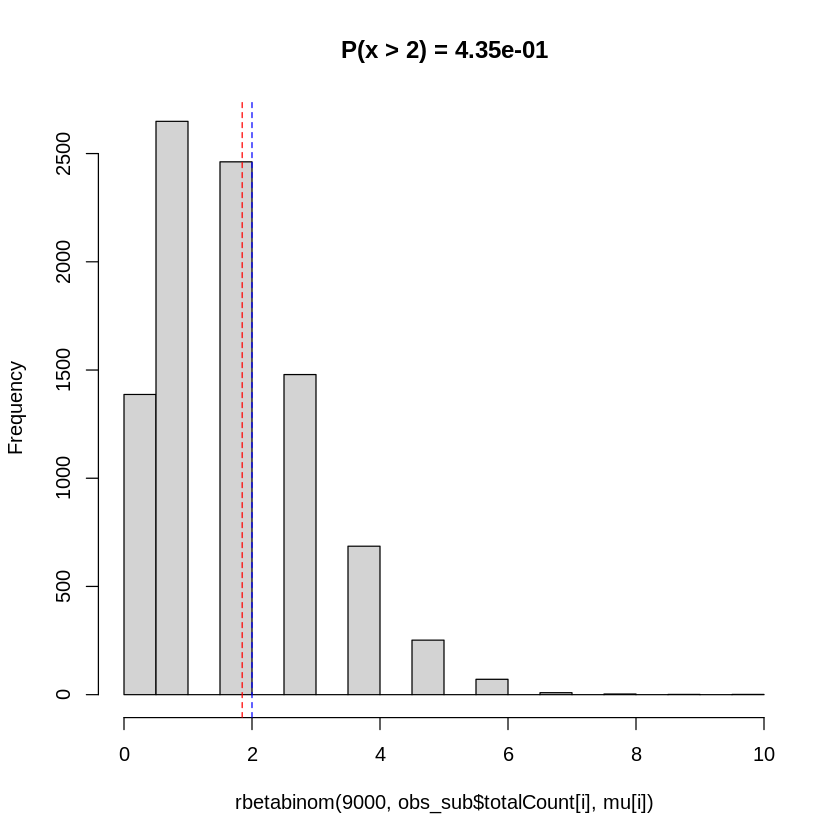

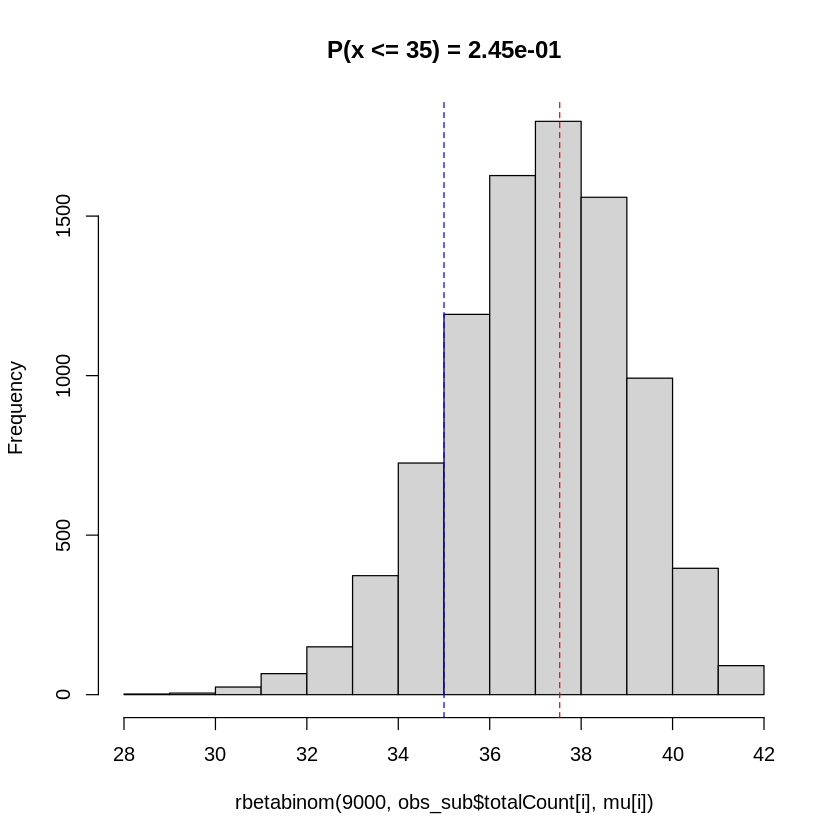

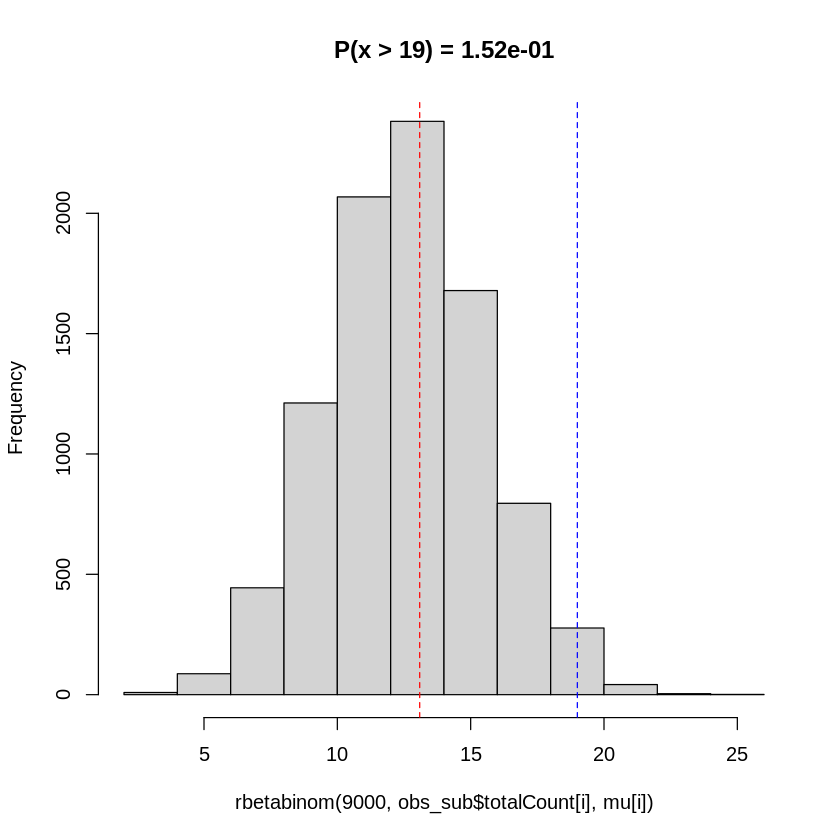

In [54]:
for (i in 1:4) {
    crit1 <- obs_sub$totalCount[i]*mu[i]
    crit2 <- obs_sub$altCount[i]
    if (is.na(crit1) | is.na(crit2)) {
        next()
    }
    if (crit2 > crit1) {
        pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
        pval =1-pbetabinom(q = obs_sub$altCount[i]-1, size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
        .title = paste0("P(x > ", round(crit2,2), ") = ", format(pval, scientific = TRUE, digits = 3))
    } else {
        pval = pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
        .title = paste0("P(x <= ", round(crit2,2), ") = ", format(pval, scientific = TRUE, digits = 3))
    }
    hist(rbetabinom(9000, obs_sub$totalCount[i], mu[i]), main = .title)
    abline(v = crit1, col = 'red', lty='dashed')
    abline(v = crit2, col = 'blue', lty='dashed')
}

In [55]:
pvals <- sapply(1:length(mu), function(i) {
    crit1 <- obs_sub$totalCount[i]*mu[i]
    crit2 <- obs_sub$altCount[i]
    if (is.na(crit1) | is.na(crit2)) {
       return(NA)
    }
    if (crit2 > crit1) {
        pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
        pval =1-pbetabinom(q = obs_sub$altCount[i]-1, size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
    } else {
        pval = pbetabinom(q = obs_sub$altCount[i], size = obs_sub$totalCount[i], prob = mu[i], rho = rho)
    }
    return(pval)
})

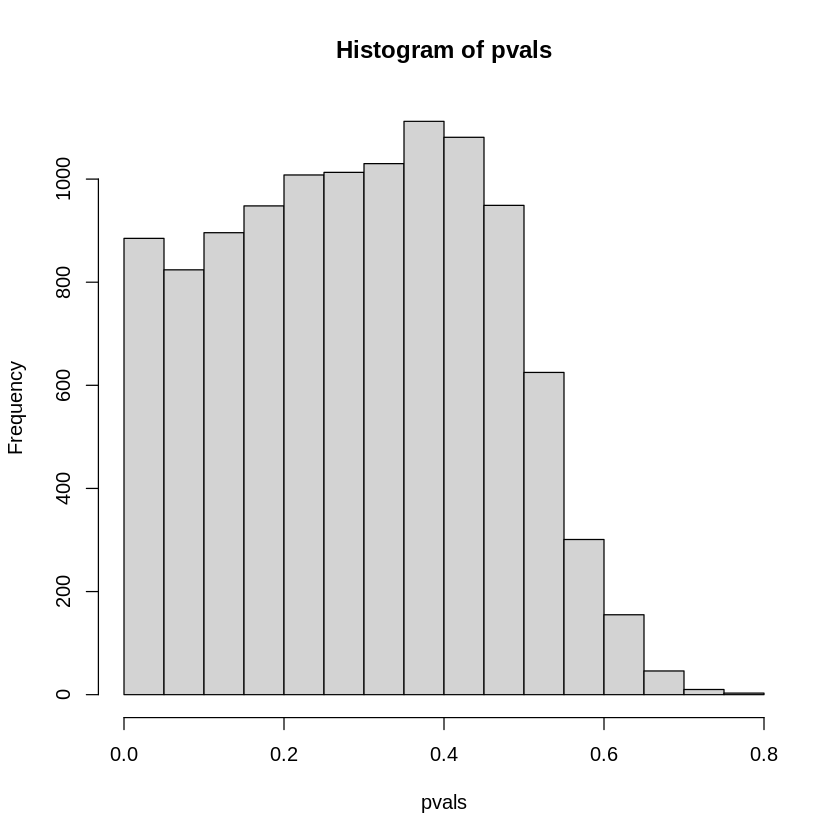

In [56]:
hist(pvals)

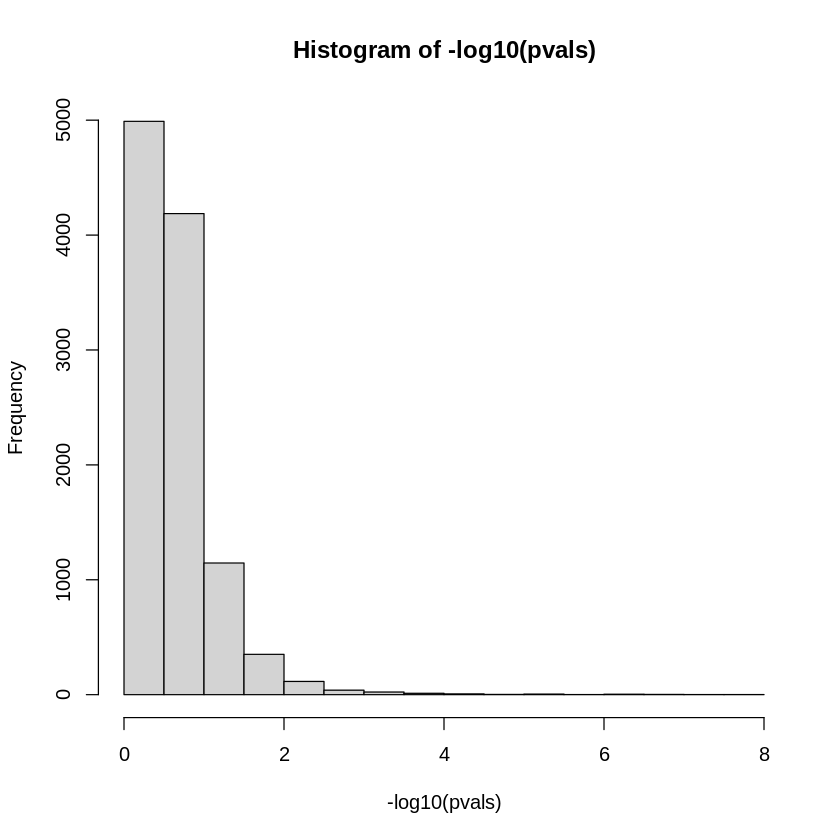

In [57]:
hist(-log10(pvals))

In [58]:
library(readr)

In [63]:
results <- mutate(obs_sub,p_value = pvals,
    direction = sapply(1:length(mu), function(i) {
        crit1 <- obs_sub$totalCount[i]*mu[i]
        crit2 <- obs_sub$altCount[i]
        if (is.na(crit1) | is.na(crit2)) {
           return(NA)
        }
        if (crit2 > crit1) {
            return("Positive")
        } else { 
            return("Negative")
        }
    }))%>%
arrange(p_value)
write_tsv(results, "~/projects/bqtls/SecondRound_bQTLs/asb/Microglia_PU1.txt")

In [65]:
fread("~/projects/bqtls/SecondRound_bQTLs/asb/Microglia_PU1.txt")

contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount,lowMAPQDepth,lowBaseQDepth,rawDepth,otherBases,p_value,direction
<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
chr17,29107428,chr17:29107428:A:T,A,T,40,1,41,0,0,41,0,1.288777e-08,Negative
chr17,29107375,chr17:29107375:T:C,T,C,47,5,52,0,0,52,0,4.087567e-08,Negative
chr6,41228296,chr6:41228296:T:C,T,C,74,4,78,0,0,78,0,1.284084e-07,Negative
chr7,37220788,chr7:37220788:C:T,C,T,1,33,34,0,0,34,0,2.025800e-07,Positive
chr5,159452861,chr5:159452861:C:G,C,G,35,7,42,0,0,42,0,4.423355e-07,Negative
chr4,38191858,chr4:38191858:A:C,A,C,2,36,38,0,0,38,0,5.947138e-07,Positive
chr6,41228302,chr6:41228302:T:C,T,C,59,4,63,0,0,63,0,8.516620e-07,Negative
chr6,41228303,chr6:41228303:C:T,C,T,59,4,63,0,0,63,0,8.516620e-07,Negative
chr2,29861183,chr2:29861183:G:A,G,A,1,33,34,0,0,35,1,1.011771e-06,Positive


In [83]:
library(stringr)

In [86]:
ld_table <- 
    fread("https://ldlink.nih.gov/LDlinkRestWeb/tmp/proxy12270.txt")%>%
    mutate(variantID = paste0(Coord, ':', str_extract(Alleles, "[AGCT]+"), ":", str_extract(Alleles, "[AGCT]+(?=.$)")))

In [88]:
results%>%inner_join(ld_table)%>%t

Joining with `by = join_by(variantID)`


contig,chr5,chr5
position,180284184,180177487
variantID,chr5:180284184:C:T,chr5:180177487:C:G
refAllele,C,C
altAllele,T,G
refCount,31,14
altCount,5,24
totalCount,36,38
lowMAPQDepth,0,0
lowBaseQDepth,0,0
rawDepth,36,38


In [91]:
results <- fread("~/projects/bqtls/SecondRound_bQTLs/asb/Monocytes_PU1.txt")

In [93]:
ld_table <- 
    fread("https://ldlink.nih.gov/LDlinkRestWeb/tmp/proxy12270.txt")%>%
    mutate(variantID = paste0(Coord, ':', str_extract(Alleles, "[AGCT]+"), ":", str_extract(Alleles, "[AGCT]+(?=.$)")))

In [94]:
results%>%inner_join(ld_table)%>%t

Joining with `by = join_by(variantID)`


contig
position
variantID
refAllele
altAllele
refCount
altCount
totalCount
lowMAPQDepth
lowBaseQDepth
rawDepth


# TODO: Calculate p-values for everything

In [5]:
geno <- arrow::read_feather("~/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather", col_select = NULL, as_data_frame = TRUE, mmap = TRUE)

In [12]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,924210,49.4,1750181,93.5,1750181,93.5
Vcells,1606324,12.3,9438125,72.1,14586236,111.3


In [16]:
monocyte_obs_files <- list.files("~/projects/bqtls/SecondRound_bQTLs/Monocytes/", "*mono_allelic_out.txt$", full.names = TRUE)
microglia_obs_files <- list.files("~/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/", "*mono_allelic_out.txt$", full.names = TRUE)

[1] "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CEBPB_mono_allelic_out.txt"  
[2] "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CTCF_mono_allelic_out.txt"   
[3] "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/H3K27ac_mono_allelic_out.txt"
[4] "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/MEF2C_mono_allelic_out.txt"  
[5] "/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/PU1_mono_allelic_out.txt"

In [2]:
results <- fread("~/projects/bqtls/SecondRound_bQTLs/asb/Monocytes_PU1.txt")

In [6]:
results <- fread("~/projects/bqtls/SecondRound_bQTLs/asb/Microglia_PU1.txt")

In [10]:
w_res <- fread("~/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Microglia_PU1.deconvolution.txt")

In [37]:
w_res <- fread("~/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Monocytes_PU1.deconvolution.txt")

In [3]:
deconv_res <- fread("~/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Monocytes_PU1.combined_data.txt")

In [69]:
deconv_res <- fread("~/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Microglia_PU1.combined_data.txt")

In [4]:
library(ggplot2)

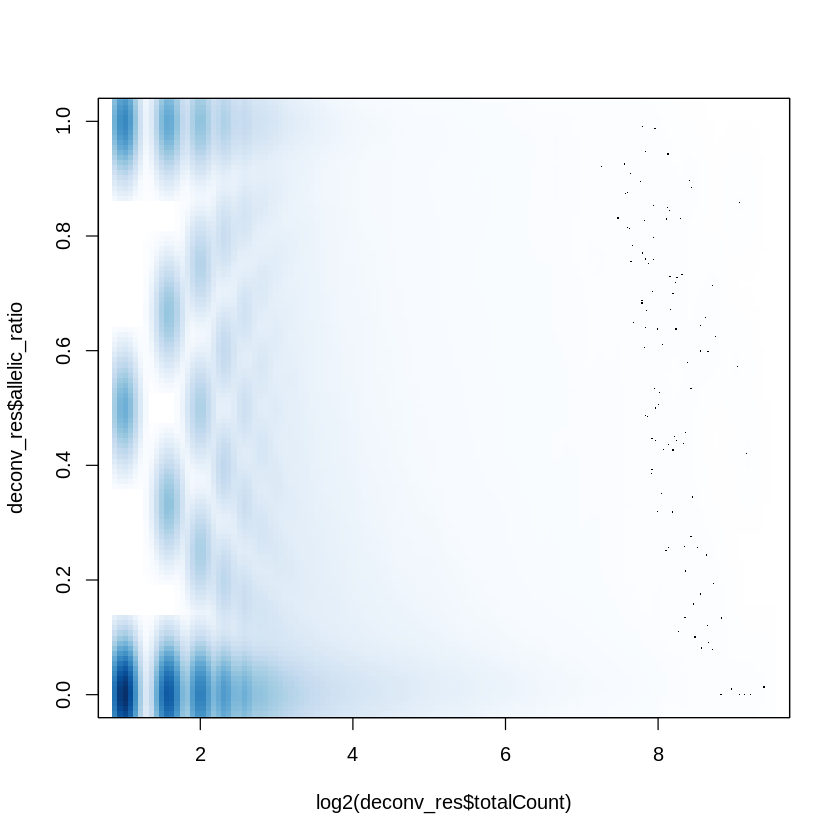

In [54]:
smoothScatter(log2(deconv_res$totalCount), deconv_res$allelic_ratio)

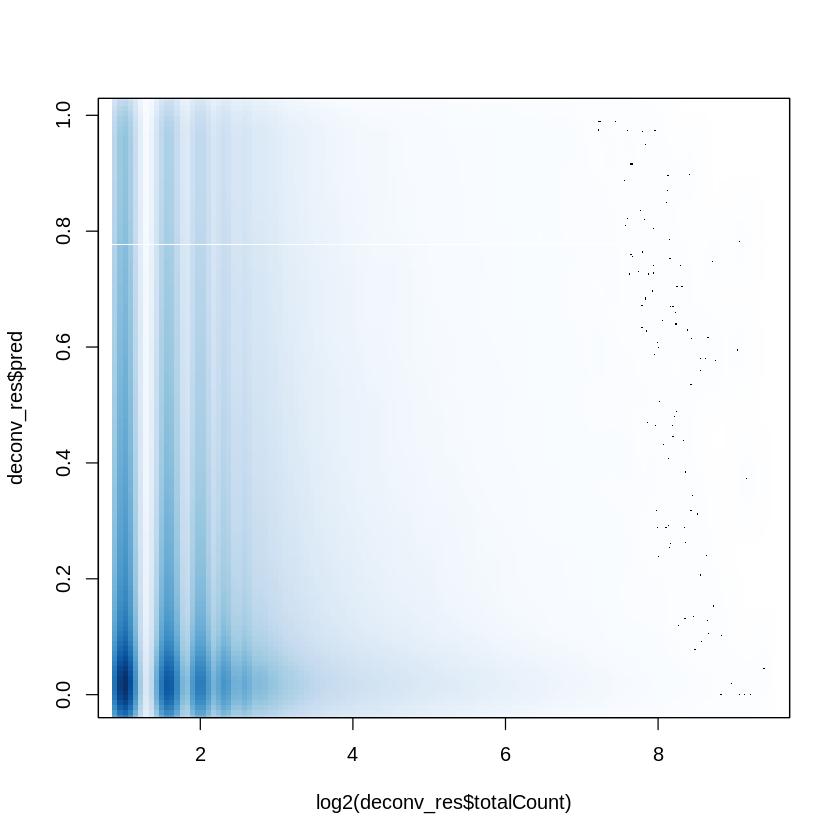

In [55]:
smoothScatter(log2(deconv_res$totalCount), deconv_res$pred)

In [70]:
names(deconv_res)[6:(dim(deconv_res)[2] - 8)]

[1] "GSA8_0_RAJBrain_NPBB306" "GSA8_0_RAJBrain_NPBB307"
 [3] "GSA8_0_RAJBrain_NPBB310" "GSA8_0_RAJBrain_NPBB314"
 [5] "GSA8_0_RAJBrain_NPBB318" "GSA8_0_RAJBrain_NPBB319"
 [7] "GSA8_0_RAJBrain_NPBB312" "GSA8_0_RAJBrain_NPBB334"
 [9] "GSA8_0_RAJBrain_NPBB324" "GSA8_0_RAJBrain_NPBB305"
[11] "GSA8_0_RAJBrain_NPBB333" "GSA8_0_RAJBrain_NPBB308"
[13] "GSA8_0_RAJBrain_NPBB316" "GSA8_0_RAJBrain_NPBB331"

In [6]:
cell_lines <- names(deconv_res)[6:(dim(deconv_res)[2] - 8)]

In [10]:
library(readr)

cell_line,estimated_representation
<chr>,<dbl>
GSA6_54_NYUMD0149-01,3.500147e-02
GSA6_8_NYUMD0179-01,3.230990e-02
GSA6_112_BIMD0195-01,3.580153e-02
GSA3-PD3_176_NYUMD0079-01,5.984158e-02
GSA4_6_NYUMD0117-01,1.253599e-05
GSA6_215_NYUMD0186-01,3.986572e-02
GSA6_22_NYUMD0177-01,4.884263e-02
GSA4_73_NYUMD0116-01,1.457168e-02
GSA6_173_NYUMD0183-01,4.764645e-02


In [162]:
x = deconv_res[1:2,..cell_lines]*2
x

GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,GSA6_112_BIMD0195-01,GSA3-PD3_176_NYUMD0079-01,GSA4_6_NYUMD0117-01,GSA6_215_NYUMD0186-01,GSA6_22_NYUMD0177-01,GSA4_73_NYUMD0116-01,GSA6_173_NYUMD0183-01,ADRC_GSA7_207_67462,⋯,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0,0,0,0,0,1,0,0,⋯,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [191]:
w = as.matrix(w_res$estimated_representation[match(cell_lines, w_res$cell_line)])

In [192]:
x1 = as.matrix(x[1,])

In [199]:
sum(t(x1) * w)/sum(w)

[1] 0.1122092

[1] 0.9896132

In [197]:
sum(x1)

[1] 5

In [158]:
i=112
x = x[i,]
w_res$estimated_representation[match(cell_lines, w_res$cell_line)] %*% unlist(x[i,])
sum(x[i,]*2, na.rm=T)
tmp$af[i]

NA


[1] 0

[1] 0.01587302

In [80]:
x[i,]

GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,GSA6_112_BIMD0195-01,GSA3-PD3_176_NYUMD0079-01,GSA4_6_NYUMD0117-01,GSA6_215_NYUMD0186-01,GSA6_22_NYUMD0177-01,GSA4_73_NYUMD0116-01,GSA6_173_NYUMD0183-01,ADRC_GSA7_207_67462,⋯,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [201]:
x1 = unlist(deconv_res[1,..cell_lines]*2)

In [204]:
w = w_res$estimated_representation[match(cell_lines, w_res$cell_line)] 

In [211]:
sum(w * x1) / sum(w) == (w %*% x1) / sum(w)

TRUE


In [221]:
tmp <- deconv_res[,..cell_lines]%>% apply(1, function(x) {
        res=list(num_homref = sum(x == 0),
                 num_het = sum(x == 0.5),
                 num_homalt = sum(x == 1),
                 num_na = sum(is.na(x)))
        res <- c(res,
            num_refalleles = res[["num_homref"]]*2,
            num_altalleles = res[["num_homalt"]]*2+res[["num_het"]])
        res$num_alleles <- res$num_refalleles + res$num_altalleles
        res$af <- with(res, num_altalleles / num_alleles)
        res$weighted_af <- (w_res$estimated_representation[match(cell_lines, w_res$cell_line)] %*% x) / (sum(w_res$estimated_representation))
        return(unlist(res))
    })%>%
    t%>%
    as.data.table

In [ ]:
# todo add weights and see if it skews the distribution even more -- I have a hunch that it does

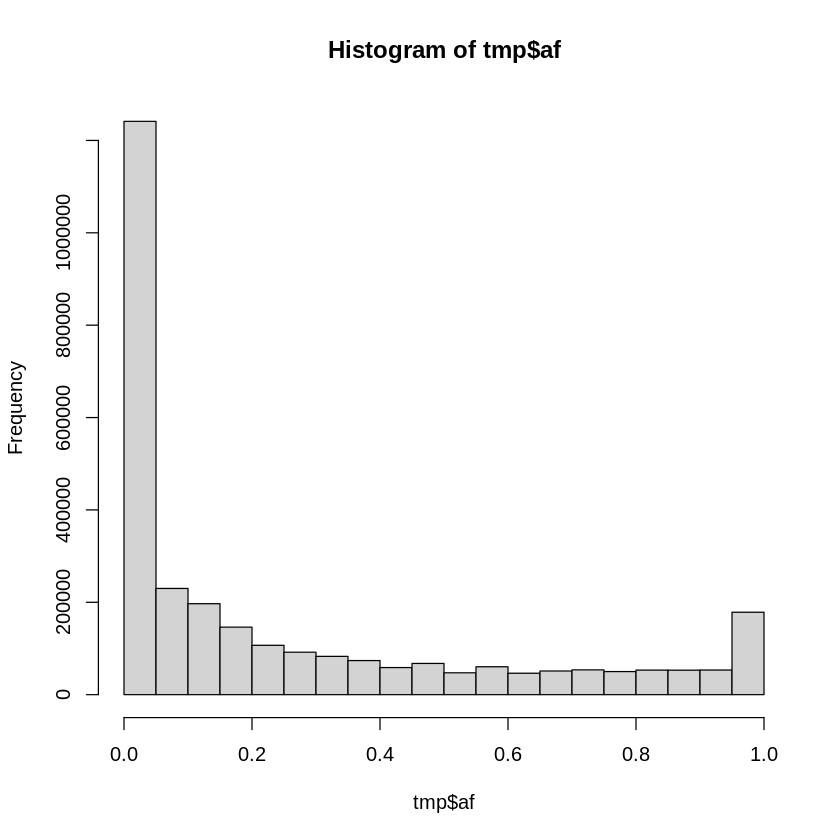

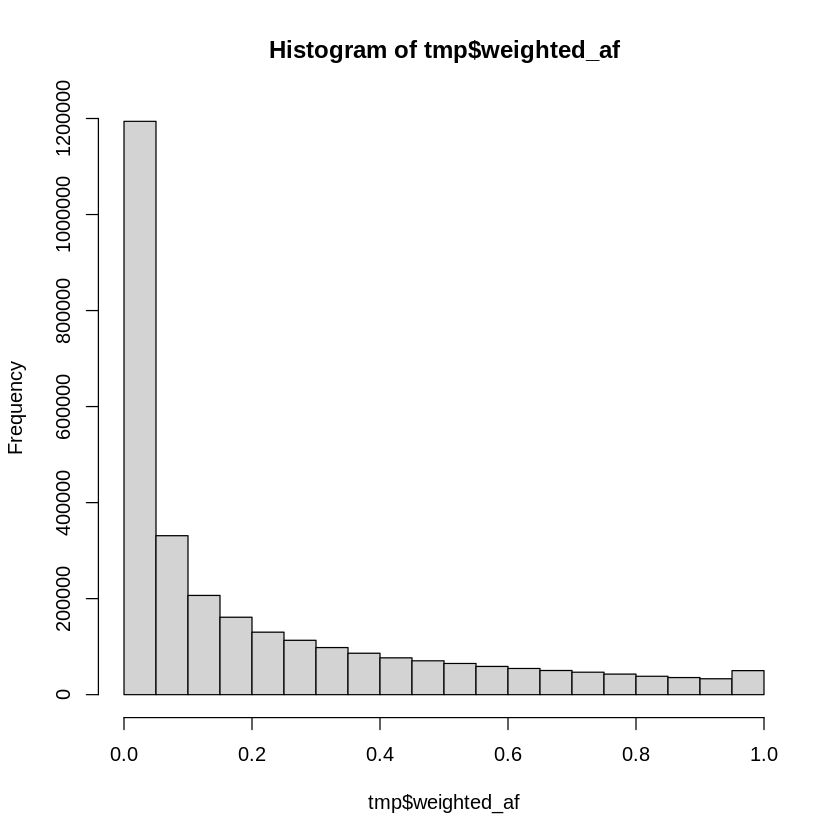

In [222]:
hist(tmp$af)
hist(tmp$weighted_af)

In [24]:
4/64

[1] 0.0625

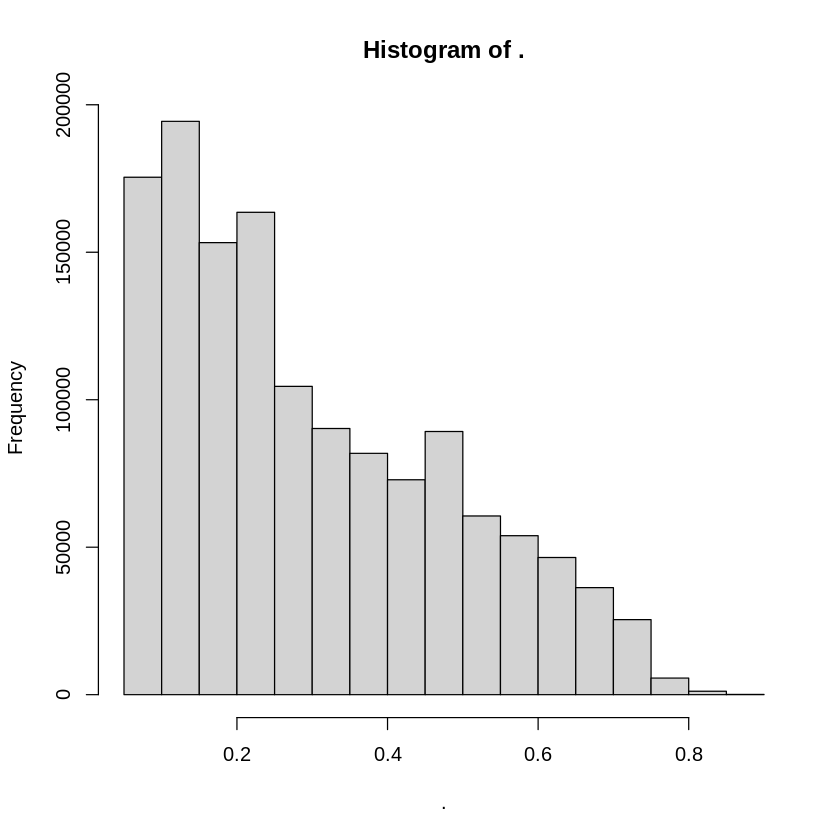

In [36]:
filter(tmp, (num_altalleles > 4 & num_refalleles > num_altalleles) |
            (num_refalleles > 4 & num_refalleles <= num_altalleles),
       num_refalleles != 64,
       num_altalleles != 64
      )%>%
(function(x) {
    #pmin(x$num_altalleles / 64,x$num_altalleles / 64)
    x$num_altalleles/64
})%>%
hist

In [16]:
filter(tmp, num_altalleles)

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `num_altalleles`.
[1mCaused by error:[22m
[33m![39m object 'num_altalleles' not found


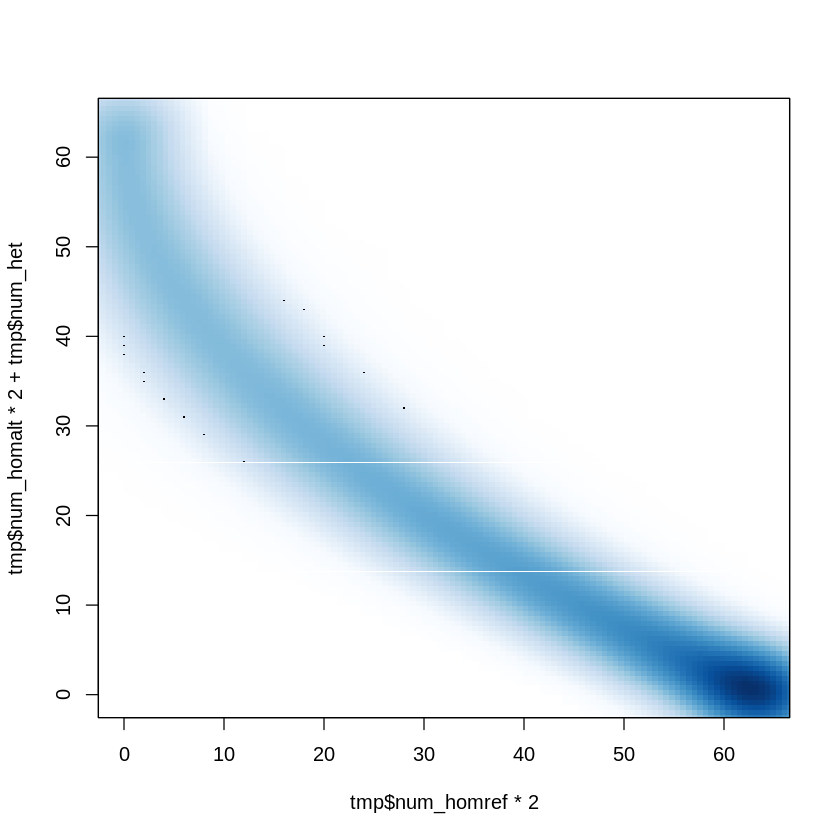

In [8]:
smoothScatter(tmp$num_homref*2, tmp$num_homalt*2 + tmp$num_het)

In [ ]:
tmp$num_homref

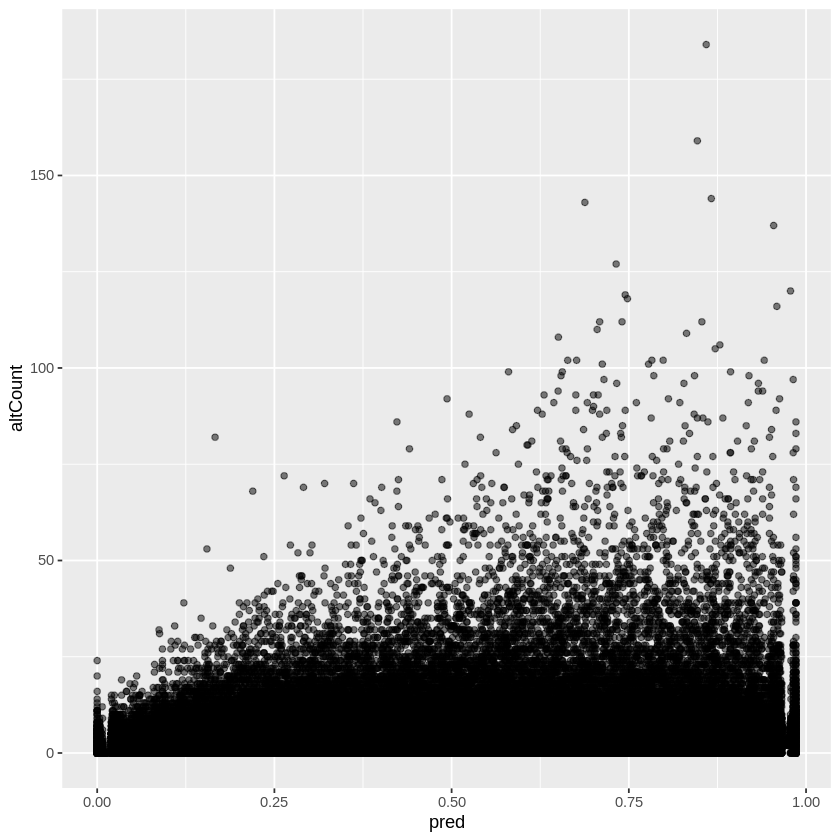

In [82]:
ggplot(deconv_res,aes(x = pred, y = altCount))+geom_point(alpha=0.5)

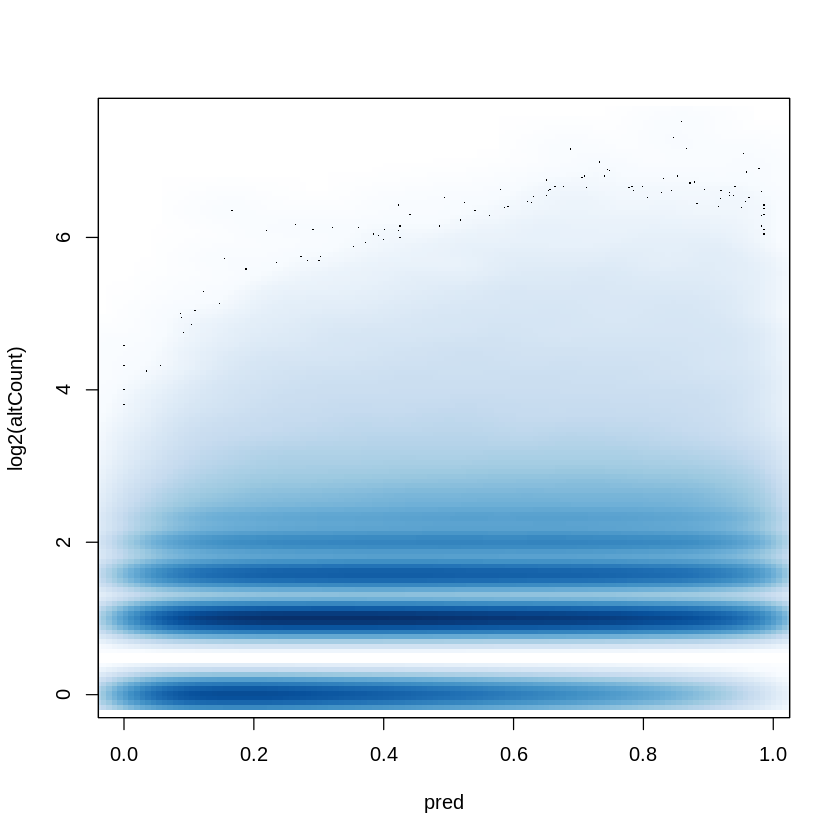

In [86]:
with(deconv_res,smoothScatter(pred, log2(altCount)))

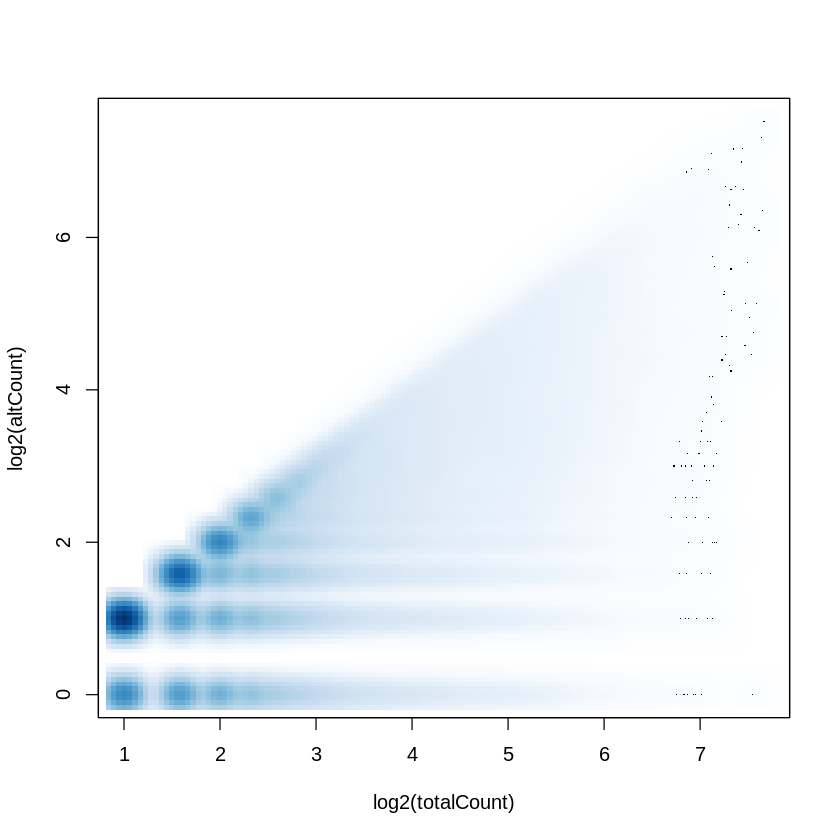

In [88]:
with(deconv_res,smoothScatter(log2(totalCount), log2(altCount)))

In [96]:
with(deconv_res%>%filter(refCount == 0, altCount == 0),smoothScatter(log(refCount), log2(altCount)))
abline(coef = c(0,1))

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in if (!missing(bandwidth) && min(bandwidth) <= 0) stop("'bandwidth' must be strictly positive"): missing value where TRUE/FALSE needed


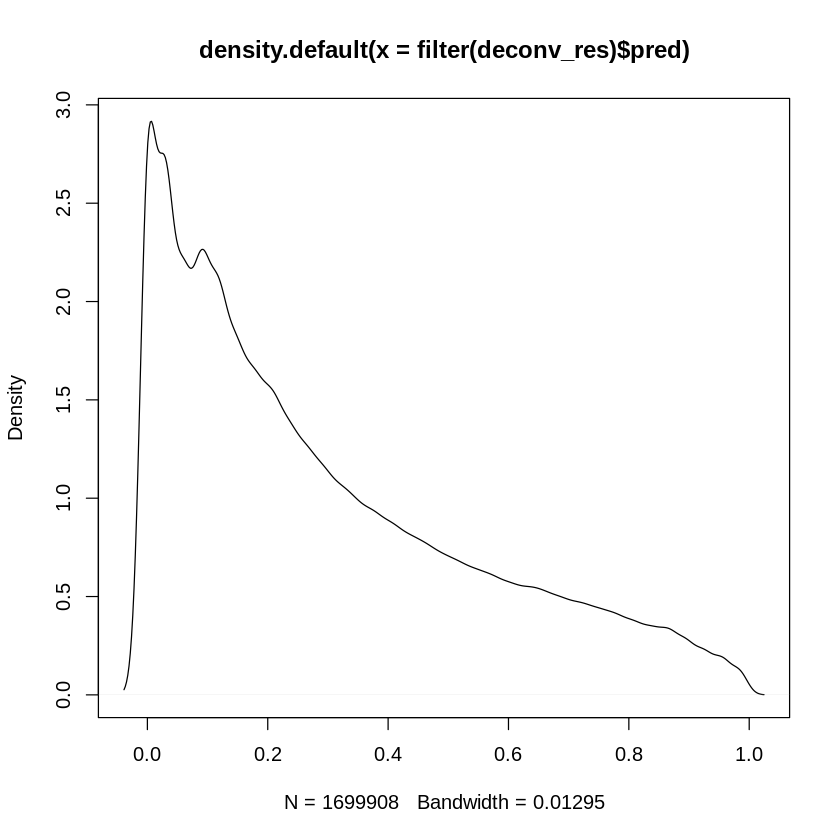

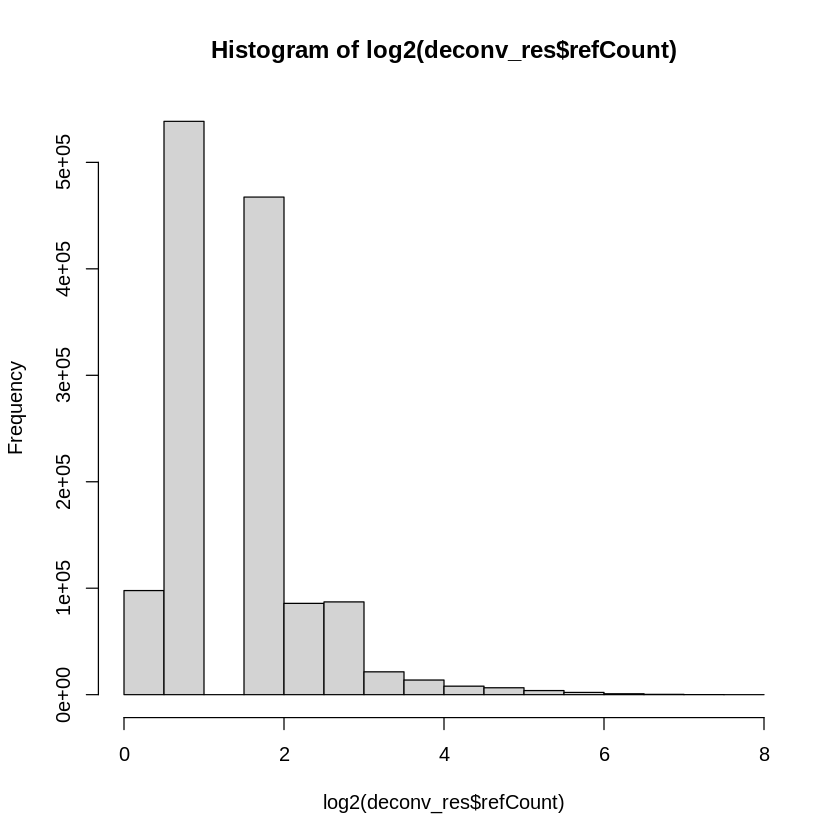

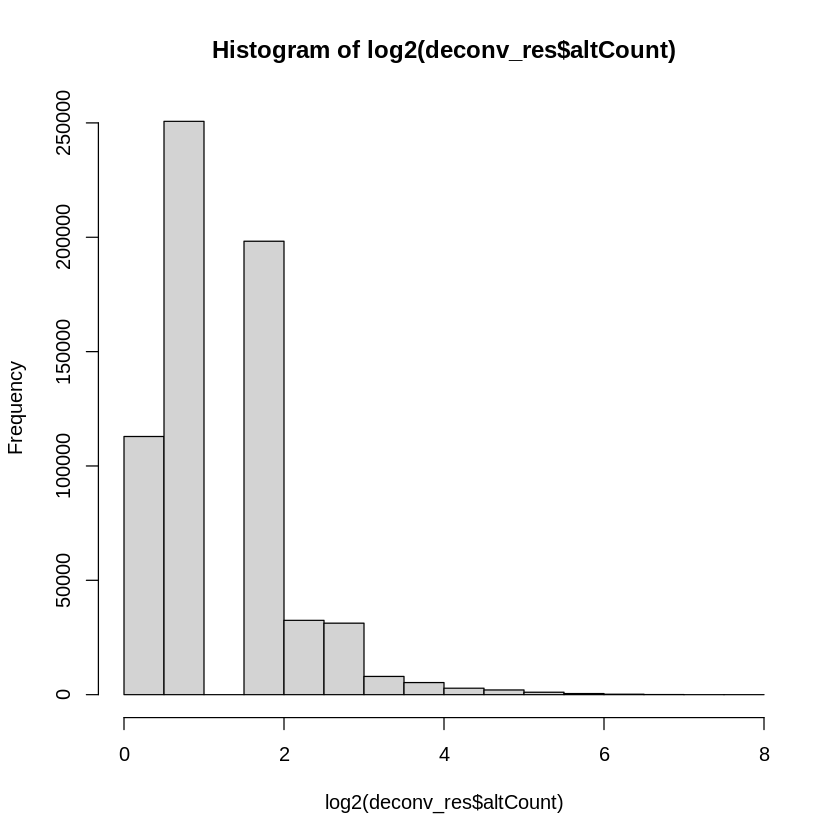

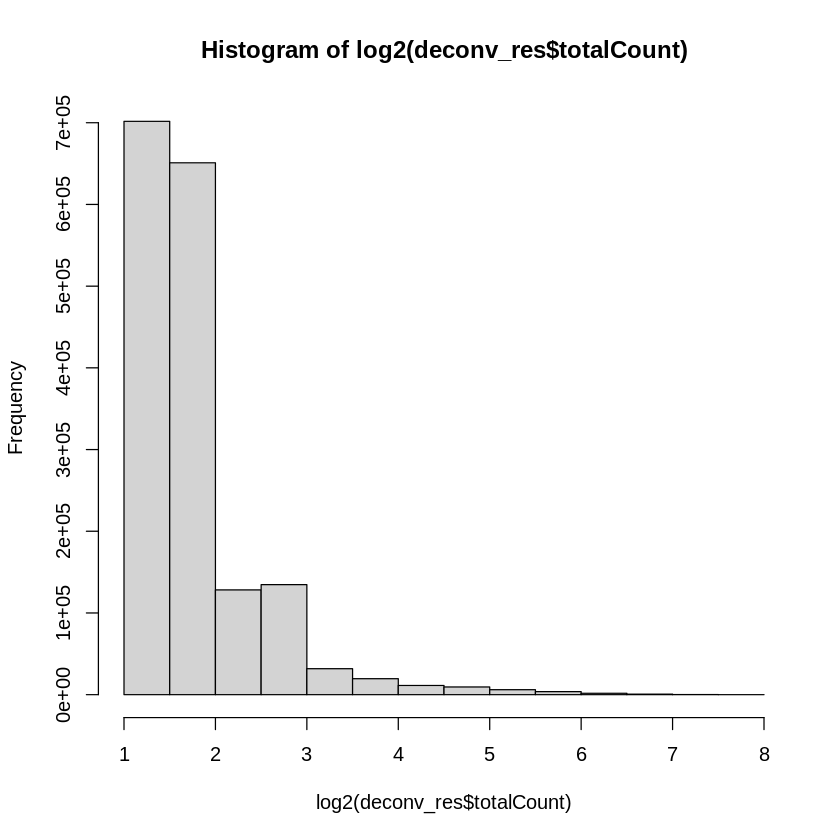

In [95]:
plot(density(filter(deconv_res)$pred))
hist(log2(deconv_res$refCount))
hist(log2(deconv_res$altCount))
hist(log2(deconv_res$totalCount))

In [ ]:
deconv_

In [20]:
deconv_res_filtered <-
deconv_res%>%
filter(maf >= 0.05, totalCount > 30)

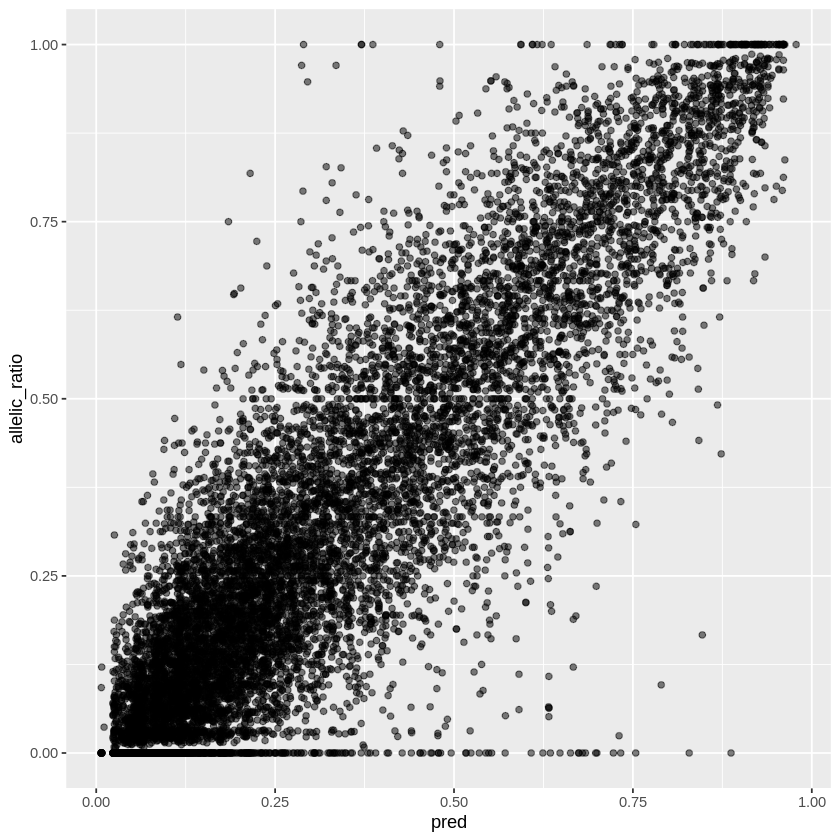

In [60]:
deconv_res_filtered%>%
ggplot(aes ( x = pred, y = allelic_ratio))+geom_point(alpha=0.5)

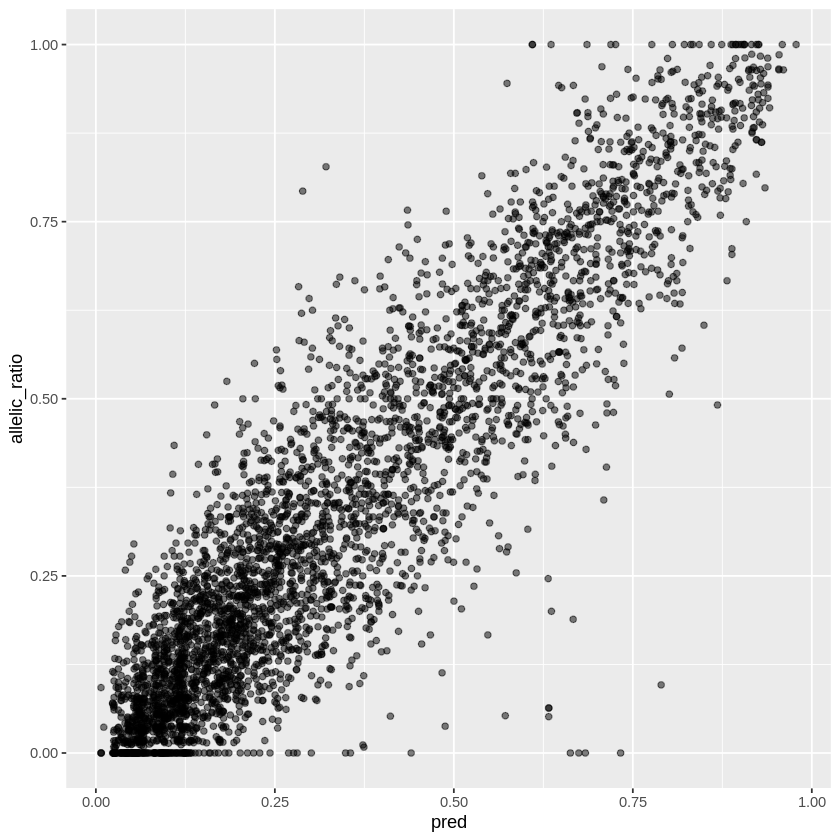

In [36]:
deconv_res_filtered%>%
filter(totalCount > 50)%>%
ggplot(aes ( x = pred, y = allelic_ratio))+geom_point(alpha=0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


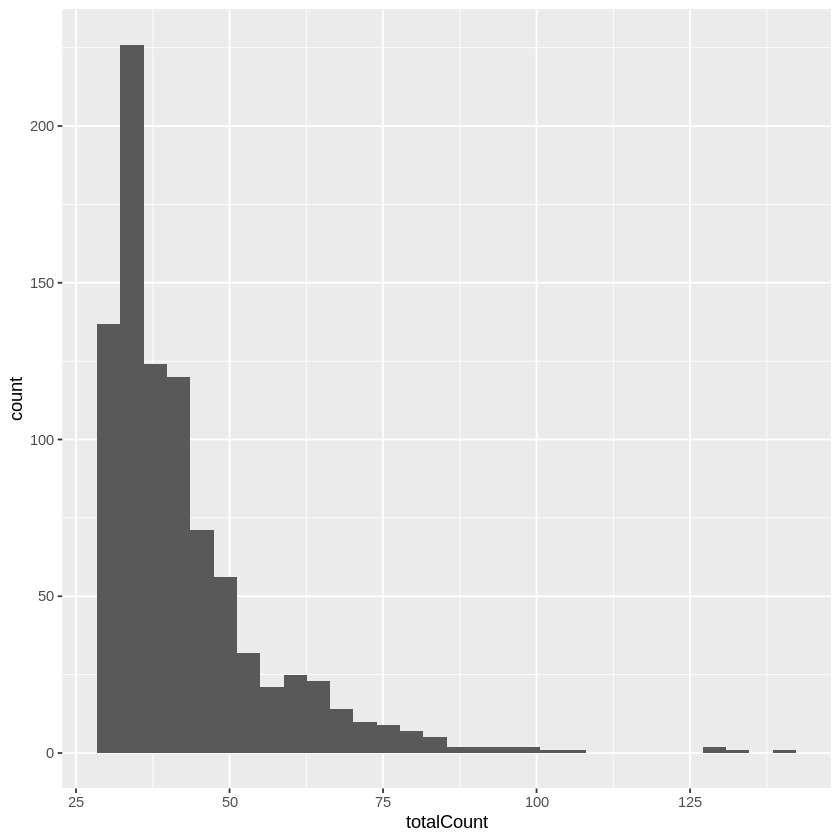

In [30]:
deconv_res_filtered%>%
filter(allelic_ratio == 0, pred > 0.01)%>%
ggplot(aes(x = totalCount))+geom_histogram()

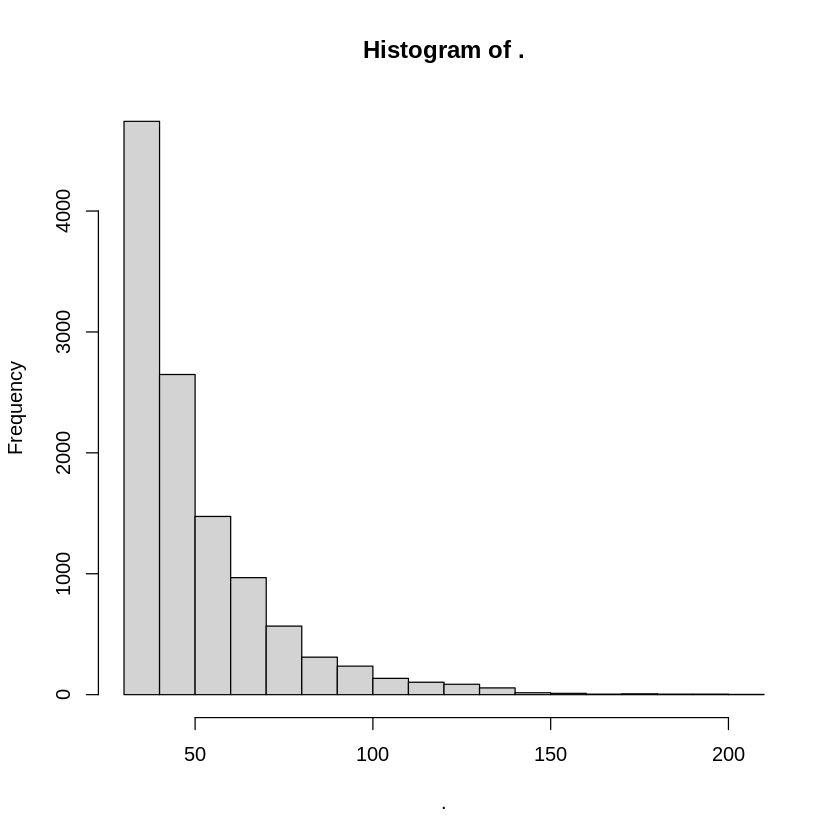

In [26]:
deconv_res_filtered$totalCount%>%hist

In [25]:
deconv_res%>%
filter(contig_x == "chr2", abs(position_x - 25307006) < 10000)

position_x,contig_x,variantID,refAllele,altAllele,GSA8_0_RAJBrain_NPBB306,GSA8_0_RAJBrain_NPBB307,GSA8_0_RAJBrain_NPBB310,GSA8_0_RAJBrain_NPBB314,GSA8_0_RAJBrain_NPBB318,⋯,GSA8_0_RAJBrain_NPBB316,GSA8_0_RAJBrain_NPBB331,contig_y,position_y,refCount,altCount,totalCount,allelic_ratio,pred,maf
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
25297988,chr2,chr2:25297988:G:A,G,A,0.5,0.5,0,0.5,0.5,⋯,1,0.0,chr2,25297988,2,0,2,0.00000000,0.236537086,0.35714286
25300327,chr2,chr2:25300327:T:C,T,C,0.0,0.0,0,0.0,0.5,⋯,0,1.0,chr2,25300327,5,0,5,0.00000000,0.103882664,0.14285714
25303763,chr2,chr2:25303763:C:T,C,T,0.5,0.5,0,0.0,0.5,⋯,1,0.0,chr2,25303763,19,0,19,0.00000000,0.179077128,0.28571429
25306755,chr2,chr2:25306755:A:C,A,C,0.5,0.5,0,0.0,1.0,⋯,1,0.5,chr2,25306755,2,7,9,0.77777778,0.264725669,0.42857143
25307006,chr2,chr2:25307006:AG:A,AG,A,0.5,0.5,1,0.5,0.0,⋯,0,0.5,chr2,25307006,49,0,49,0.00000000,0.516976072,0.39285714
25307159,chr2,chr2:25307159:T:C,T,C,0.5,0.5,0,0.0,1.0,⋯,1,0.5,chr2,25307159,9,6,15,0.40000000,0.264725669,0.42857143
25308338,chr2,chr2:25308338:T:G,T,G,0.5,0.5,0,0.0,1.0,⋯,1,0.5,chr2,25308338,4,0,4,0.00000000,0.264725669,0.42857143
25308481,chr2,chr2:25308481:G:A,G,A,0.5,0.5,0,0.0,0.5,⋯,1,0.0,chr2,25308481,2,2,4,0.50000000,0.179077128,0.28571429
25308910,chr2,chr2:25308910:A:G,A,G,0.5,0.5,0,0.0,1.0,⋯,1,0.5,chr2,25308910,3,3,6,0.50000000,0.264725669,0.42857143


In [24]:
w_res

cell_line,estimated_representation
<chr>,<dbl>
GSA8_0_RAJBrain_NPBB306,0.046220199
GSA8_0_RAJBrain_NPBB307,0.119967755
GSA8_0_RAJBrain_NPBB310,0.161393442
GSA8_0_RAJBrain_NPBB314,0.074682301
GSA8_0_RAJBrain_NPBB318,0.055995866
GSA8_0_RAJBrain_NPBB319,0.006685053
GSA8_0_RAJBrain_NPBB312,0.065462867
GSA8_0_RAJBrain_NPBB334,0.048505348
GSA8_0_RAJBrain_NPBB324,0.040237616


In [8]:
results <- results%>%mutate(qval = p.adjust(p_value, method = 'fdr'))

In [9]:
results

contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount,lowMAPQDepth,lowBaseQDepth,rawDepth,otherBases,p_value,direction,qval
<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>
chr17,29107428,chr17:29107428:A:T,A,T,40,1,41,0,0,41,0,1.288777e-08,Negative,0.0001402963
chr17,29107375,chr17:29107375:T:C,T,C,47,5,52,0,0,52,0,4.087567e-08,Negative,0.0002224863
chr6,41228296,chr6:41228296:T:C,T,C,74,4,78,0,0,78,0,1.284084e-07,Negative,0.0004659515
chr7,37220788,chr7:37220788:C:T,C,T,1,33,34,0,0,34,0,2.025800e-07,Positive,0.0005513214
chr5,159452861,chr5:159452861:C:G,C,G,35,7,42,0,0,42,0,4.423355e-07,Negative,0.0009630528
chr4,38191858,chr4:38191858:A:C,A,C,2,36,38,0,0,38,0,5.947138e-07,Positive,0.0010790091
chr6,41228302,chr6:41228302:T:C,T,C,59,4,63,0,0,63,0,8.516620e-07,Negative,0.0011588991
chr6,41228303,chr6:41228303:C:T,C,T,59,4,63,0,0,63,0,8.516620e-07,Negative,0.0011588991
chr2,29861183,chr2:29861183:G:A,G,A,1,33,34,0,0,35,1,1.011771e-06,Positive,0.0012237930
